In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
# Step 2: Enable interactive mode for Jupyter Notebook
%matplotlib inline
np.set_printoptions(formatter={'float_kind': lambda x: f"{x:0.6f}"})

# 1. Load and display data

In [2]:
df = pd.read_excel('data3.xlsx')

In [3]:
df

,x1,x2,x3,y,Notes
0,0.151837,0.439991,0.990882,-0.398926,NaN
1,0.746912,0.284196,0.226300,-0.131461,NaN
2,0.046809,0.231360,0.770618,-0.118048,NaN
3,0.645503,0.397143,0.919771,-0.113869,NaN
4,0.171525,0.343917,0.248737,-0.112122,NaN
...,...,...,...,...,...
67,0.000000,0.021280,0.864075,-0.141232,14/7 refreshed
68,0.402970,0.542286,0.412265,-0.004020,14/7 refreshed
69,0.474332,0.555957,0.446102,-0.005993,14/7 refreshed
70,0.390104,0.476671,0.550932,-0.019791,17/7 BO 2*std exp 0.17


In [4]:
df = df.drop(columns=['Notes'])
df=df.dropna()

In [5]:
df

,x1,x2,x3,y
0,0.151837,0.439991,0.990882,-0.398926
1,0.746912,0.284196,0.226300,-0.131461
2,0.046809,0.231360,0.770618,-0.118048
3,0.645503,0.397143,0.919771,-0.113869
4,0.171525,0.343917,0.248737,-0.112122
...,...,...,...,...
67,0.000000,0.021280,0.864075,-0.141232
68,0.402970,0.542286,0.412265,-0.004020
69,0.474332,0.555957,0.446102,-0.005993
70,0.390104,0.476671,0.550932,-0.019791


# 2. Visualise data on plots

In [6]:
# two highest points in top_2_indices will have color in red
top_2_indices = df['y'].nlargest(2).index
top_qntl_index = df['y'].nlargest(int(df.shape[0]/4.0)).index
colors = np.full(df.shape[0], 'b', dtype=object)  # Default color is blue
colors[top_qntl_index] = 'y'
colors[top_2_indices[0]] = 'r'  # Color top points red

In [7]:
df.iloc[top_2_indices,:]

,x1,x2,x3,y
23,0.461584,0.588622,0.475405,0.022928
44,0.474332,0.555957,0.446102,-0.000284


In [8]:
# It seems the noise is increasing to the point of 15

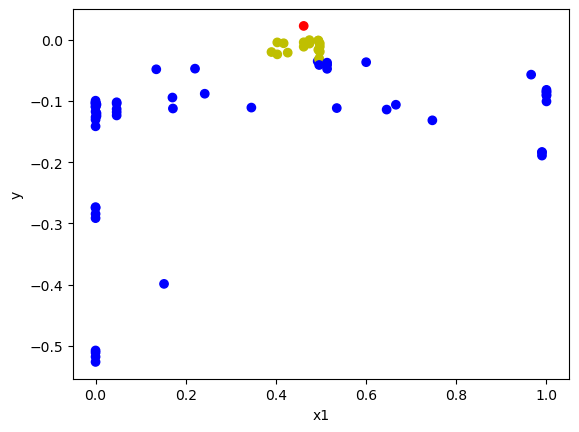

In [9]:
plt.scatter(df['x1'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x1')
plt.show()

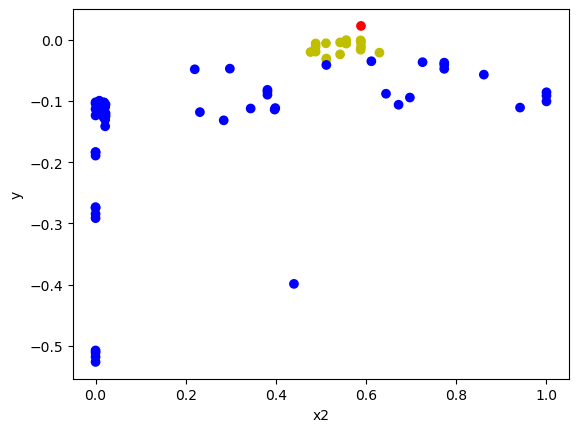

In [10]:
plt.scatter(df['x2'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x2')
plt.show()

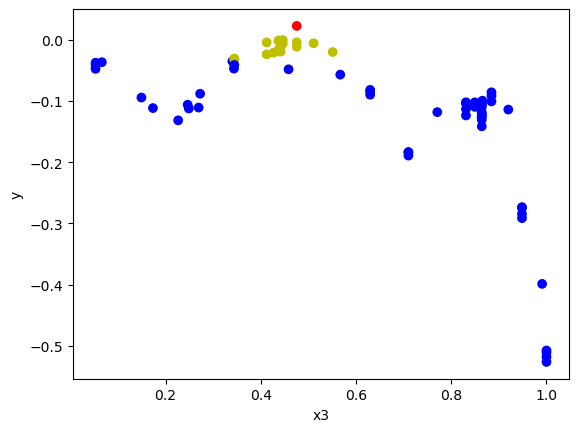

In [11]:
plt.scatter(df['x3'],df['y'], c = colors)
# Highlight the two highest y values
plt.ylabel('y')
plt.xlabel('x3')
plt.show()

# You can rotate 3 dimentions with color - y values

<IPython.core.display.Javascript object>


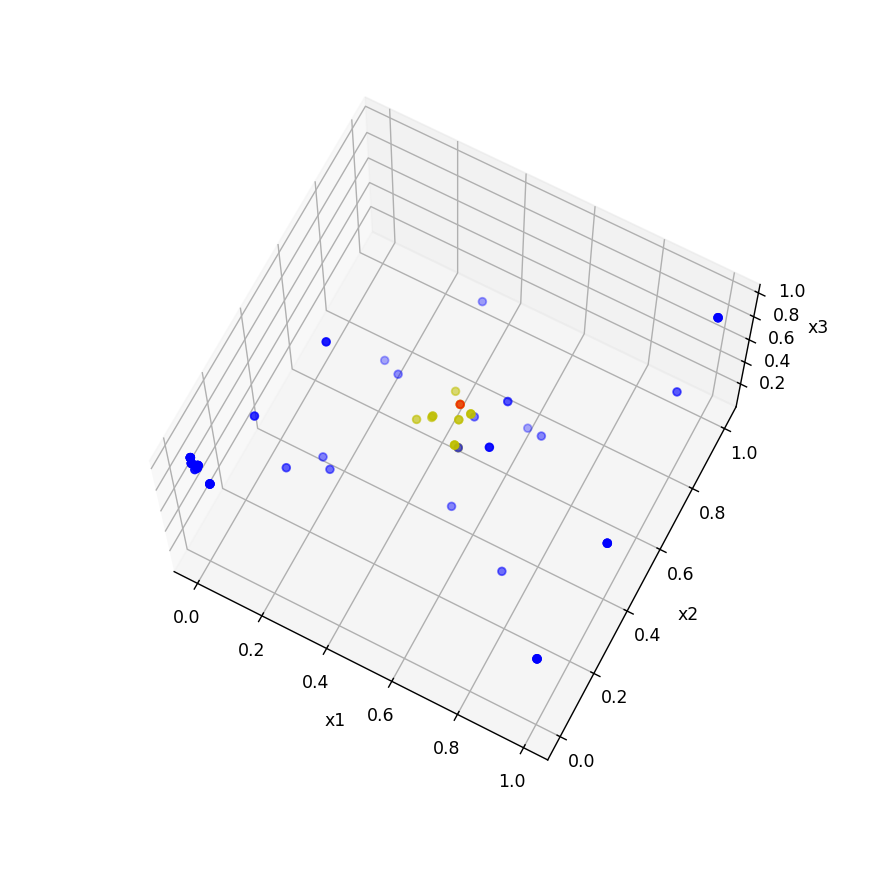

In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
ax.scatter(df['x1'], df['x2'], df['x3'], c = colors)
# Set labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
# Display the plot
plt.show()

In [13]:
%matplotlib inline

# 3. Build the grid for Optimization
fine tune the size of grid for high dimention!

In [14]:
x = np.linspace(0,0.999999,50).reshape(-1,1)

In [15]:
x_grid = np.array([[x1, x2, x3] for x1 in x for x2 in x for x3 in x])
x_grid = x_grid.squeeze()

In [16]:
# Prepare X and y for optimization tools
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy().reshape(-1,1)

# 4. Use Gaussian Process Regressor with Radial Based Function and WhiteKernel (because of noise)

In [17]:
kernel = RBF(length_scale = 0.5, length_scale_bounds=(1e-3, 1e5)) + \
    WhiteKernel(noise_level = 0.02, noise_level_bounds=(1e-10, 1e2))
bo_model = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=1000, normalize_y=True)

In [18]:
bo_model.fit(X, y)

GaussianProcessRegressor(alpha=0.0,
                         kernel=RBF(length_scale=0.5) + WhiteKernel(noise_level=0.02),
                         n_restarts_optimizer=1000, normalize_y=True)

In [19]:
# Check that predicted values are equal originals - this is just a control point
np.column_stack( (y,bo_model.predict(X)) )

array([[-0.398926, -0.397315],
       [-0.131461, -0.131367],
       [-0.118048, -0.118061],
       [-0.113869, -0.113875],
       [-0.112122, -0.111942],
       [-0.111415, -0.111422],
       [-0.110621, -0.110644],
       [-0.105965, -0.105947],
       [-0.094190, -0.094278],
       [-0.087963, -0.088073],
       [-0.056758, -0.057089],
       [-0.048008, -0.048304],
       [-0.046947, -0.047348],
       [-0.036378, -0.036689],
       [-0.034835, -0.035136],
       [-0.126348, -0.113898],
       [-0.105789, -0.113898],
       [-0.085583, -0.092441],
       [-0.091088, -0.092441],
       [-0.030374, -0.034582],
       [-0.032365, -0.034582],
       [-0.005791, -0.012222],
       [-0.010868, -0.012222],
       [0.022928, 0.002177],
       [-0.003810, 0.002177],
       [-0.183284, -0.185296],
       [-0.189133, -0.185296],
       [-0.284525, -0.283242],
       [-0.274723, -0.283242],
       [-0.511280, -0.513891],
       [-0.518162, -0.513891],
       [-0.103614, -0.107619],
       [-0.

In [20]:
bo_model.kernel_

RBF(length_scale=0.0942) + WhiteKernel(noise_level=0.00571)

In [21]:
# Predict for the grid
post_mean, post_std = bo_model.predict(x_grid, return_std=True)

In [22]:
# Define aquiring function, you can change 2 to 1 or 0 depends upon the strategy 
a_fun = post_mean + 2 * post_std

In [23]:
# Find the index and maximum value of aquiring function
i = np.argmax(a_fun)
print('The maximum of acquiring function is', a_fun[i],'the max index is',i)
print('post_mean =', post_mean[i],' post_std =', post_std[i])
print('the next point for Bayesian Optimization is',x_grid[i])

The maximum of acquiring function is 0.1636879838523156 the max index is 45921
post_mean = -0.06774676998762741  post_std = 0.1157173769199715
the next point for Bayesian Optimization is [0.367347 0.367347 0.428571]


In [24]:
# I would like to find out the points even better than grid
# I use optimize.minimize function over bayesian predictor
# This piece of code is useful for multi-dimentionsfrom scipy.optimize import minimizefrom scipy.optimize import minimize
def aquisition_fun(x):
    x = np.atleast_2d(x)
    post_mean, post_std = bo_model.predict(x, return_std=True)
    return -(post_mean + 2 * post_std )
result = minimize(aquisition_fun, x_grid[i], bounds=[(0, 0.999999)]*3, tol=1e-8)
optimal_point = result.x
optimal_value = -result.fun
print(f"Optimal value {optimal_value:0.6f}")
print("at point", optimal_point)

Optimal value 0.164018
at point [0.370386 0.375136 0.432791]


# Use Seconf attempt for Gaussian Process Regressor with Radial Based Function and WhiteKernel

In [25]:
# Define aquiring function
a_fun = post_mean + 1 * post_std
# Find the index and maximum value of aquiring function
i = np.argmax(a_fun)
print('The maximum of aquering function is', a_fun[i],'the max index is',i)
print('the next point for Bayesian Optimization is',x_grid[i])

The maximum of aquering function is 0.056159548725836325 the max index is 51022
the next point for Bayesian Optimization is [0.408163 0.408163 0.448979]


In [26]:
from scipy.optimize import minimize
def aquisition_fun(x):
    x = np.atleast_2d(x)
    post_mean, post_std = bo_model.predict(x, return_std=True)
    return -(post_mean + 1 * post_std )
result = minimize(aquisition_fun, x_grid[i], bounds=[(0, 0.999999)]*3, tol=1e-8)
optimal_point = result.x
optimal_value = -result.fun
print(f"Optimal value {optimal_value:0.6f}")
print("at point", optimal_point)

Optimal value 0.056387
at point [0.399815 0.413034 0.447517]


# 5. Find the next point based on gradient in max point

In [27]:
# Find the maximum value in y and its index
max_index = top_2_indices[0]
max_value = y[max_index]
print("Some analytics for hyperplain:")
print('max value =', max_value)
# Calculate distances from the point with maximum y to all other points
distances = np.linalg.norm(X - X[max_index], axis=1)
closest_indices = np.argsort(distances)[1:13] #<- To fine tune the number of points to research & build surrounding plane 
indices_to_use = np.concatenate(([max_index], closest_indices))
# Show average distance of closest points. Step should not be far away
mean_dist = distances[indices_to_use].mean()
print("Average distance",mean_dist)
# Extract the points and their corresponding y values
X_selected = X[indices_to_use]
y_selected = y[indices_to_use]
# Fit a linear hyperplane using the selected points
l2_model = LinearRegression()
l2_model.fit(X_selected, y_selected, sample_weight = 4/(1 + 4 * distances[indices_to_use]/mean_dist))
# Coefficients of the linear hyperplane
coefficients = l2_model.coef_
intercept = l2_model.intercept_
# Calculate the covariance matrix of the feature matrix X
cov_matrix = np.cov(X_selected, rowvar=False)
# Calculate the determinant of the covariance matrix
det_cov_matrix = np.linalg.det(cov_matrix)
print("Determinant of the covariance matrix should not be 0:", det_cov_matrix)
# Define the maximum point
max_point = X[max_index]
# Calculate the gradient of the hyperplane
gradient = coefficients
# THIS IS IMPORTANT
# Define the distance to move along the gradient direction depends on surroundings and predicted value
distance = 0.01 # <- To fine tune the distance
# Normalize the gradient to unit length
gradient_unit = gradient / np.linalg.norm(gradient)
# Move from the maximum point in the direction of the gradient by the specified distance
highest_point_on_hyperplane = np.clip(max_point + distance * gradient_unit, 0, 0.999999)
# Calculate the y value at this highest point
highest_y_value_on_hyperplane = l2_model.predict(highest_point_on_hyperplane)[0]
print("X selected points, Y selected,Y predicted, Distance from max")
print(np.column_stack( (X_selected, y_selected, l2_model.predict(X_selected), distances[indices_to_use])))
print("Highest point on hyperplane within",distance,"distance:", highest_point_on_hyperplane)
print("Highest y value on hyperplane within",distance,"distance:", highest_y_value_on_hyperplane)
print("Gradient",gradient)
point1 = highest_point_on_hyperplane

Some analytics for hyperplain:
max value = [0.022928]
Average distance 0.05523428054941373
Determinant of the covariance matrix should not be 0: 1.3767802799728607e-09
X selected points, Y selected,Y predicted, Distance from max
[[0.461584 0.588622 0.475405 0.022928 0.012111 0.000000]
 [0.461584 0.588622 0.475405 -0.003810 0.012111 0.000000]
 [0.461584 0.588622 0.475405 0.022928 0.012111 0.000000]
 [0.474332 0.555957 0.446102 -0.005993 -0.003018 0.045697]
 [0.474332 0.555957 0.446102 -0.000284 -0.003018 0.045697]
 [0.493976 0.587915 0.437323 -0.001032 -0.001923 0.050000]
 [0.493976 0.587915 0.437323 -0.016017 -0.001923 0.050000]
 [0.493976 0.587915 0.437323 -0.001032 -0.001923 0.050000]
 [0.426112 0.629558 0.426838 -0.020764 -0.004937 0.072751]
 [0.417078 0.510942 0.510849 -0.005415 0.015405 0.096287]
 [0.402970 0.542286 0.412265 -0.023579 -0.022168 0.097823]
 [0.402970 0.542286 0.412265 -0.004020 -0.022168 0.097823]
 [0.497320 0.488060 0.441534 -0.010868 -0.011526 0.111969]]
Highest p

In [28]:
# Check the model score, it should be close to 1
l2_model.score(X_selected, y_selected)

0.2655672417819439

In [29]:
# It does not work well

In [30]:
# Check the distance from max point
np.linalg.norm(highest_point_on_hyperplane - X[max_index])

0.009999999999999966

In [31]:
# Check what Bayesian think about this point
bo_model.predict(highest_point_on_hyperplane)

array([0.001780])

In [32]:
# See covariance matrix to control multicolinearity
print("Covariance matrix:\n", cov_matrix)

Covariance matrix:
 [[0.001229 0.000171 0.000071]
 [0.000171 0.001454 -0.000117]
 [0.000071 -0.000117 0.000799]]


In [33]:
# Check what Bayesian think about this point
bo_model.predict(highest_point_on_hyperplane)

array([0.001780])

In [34]:
# Do prinicple components analysis of data seleted for plain surface to double check multicol.
from sklearn.decomposition import KernelPCA, PCA
pca = PCA(n_components = 3)
X_lin = pca.fit(X_selected)
X_lin.explained_variance_ratio_

array([0.446031, 0.336826, 0.217143])

# 6. Aproximate by quadratic polinome at max point 

In [35]:
def num_of_nonl_param(n):
    # function returns the number of minimum points for quadratic polynomal
    n = np.array(n)
    return int(1 + 2 * n + n * (n-1) / 2)

In [36]:
poly = PolynomialFeatures(2, include_bias = False)
XN = poly.fit_transform(X)

In [37]:
max_index=np.argmax(y) 
max_value = y[max_index]
#print('max value =', max_value)
# Calculate distances from the point with maximum y to all other points
distances = np.linalg.norm(X - X[max_index], axis=1)

In [38]:
def apprF(n):
    # Sort the distances and get the indices of the two closest neighbors (excluding itself)
    # THE NUMBER OF POINTS IS EQUIAL TO THE TOTAL DIMENTIONALITY!!!
    closest_indices = np.argsort(distances)[1:n]
    # Indices of the three points (max point + two closest neighbors)
    indices_to_use = np.concatenate(([max_index], closest_indices))
    #print('indices to use', indices_to_use)
    # Show overage distance of closest points. Step should not be far away
    print("Average distance",distances[indices_to_use].mean())
    # Extract the points and their corresponding y values
    XN_selected = XN[indices_to_use]
    y_selected = y[indices_to_use]
    # print(X_selected)
    # Fit a linear hyperplane using the selected points
    lreg = LinearRegression()
    lreg.fit(XN_selected, y_selected)
    print(np.column_stack( (y_selected, lreg.predict(XN_selected)) ))
    print(lreg.score(XN_selected,y_selected))
    return lreg

In [39]:
num_of_nonl_param(3)

10

In [40]:
lreg = apprF(22)

Average distance 0.10567468405337412
[[0.022928 0.007855]
 [-0.003810 0.007855]
 [0.022928 0.007855]
 [-0.005993 -0.001002]
 [-0.000284 -0.001002]
 [-0.001032 -0.000143]
 [-0.016017 -0.000143]
 [-0.001032 -0.000143]
 [-0.020764 -0.015771]
 [-0.005415 -0.003453]
 [-0.023579 -0.016680]
 [-0.004020 -0.016680]
 [-0.010868 -0.014448]
 [-0.019113 -0.014448]
 [-0.005791 -0.014448]
 [-0.034835 -0.039917]
 [-0.019791 -0.016598]
 [-0.040959 -0.032802]
 [-0.030374 -0.032802]
 [-0.032365 -0.032802]
 [-0.087963 -0.087658]
 [-0.105965 -0.106737]]
0.9300961122659952


In [41]:
X0 = X[max_index,:] 

In [42]:
def opt_fun(x):
    polynom = poly.fit_transform(x.reshape(1, -1))
    return -lreg.predict(polynom)

In [43]:
# Define boundaries as the solution is not stable
step = 0.9
bnds = []
for i in range(0,len(X0)): bnds.append( (max(X0[i]-step,0), min(X0[i]+step,0.999999)) )
print('Bonds\n', np.array(bnds))

Bonds
 [[0.000000 0.999999]
 [0.000000 0.999999]
 [0.000000 0.999999]]


In [44]:
result = minimize(opt_fun, X0, bounds=bnds, tol=1e-5)

In [45]:
print('The next point is',result.x)
print(f'Estimated error{result.fun:0.3f}')

The next point is [0.999999 0.905273 0.999999]
Estimated error-0.516


In [46]:
X0

array([0.461584, 0.588622, 0.475405])

In [47]:
# It does not work well